In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap # needs python 3.8?
import sys # to check python version
import os
import glob
import datetime as dt

### note: remove zeros from training ds and replace them with -999 flag

In [2]:
t1 = dt.datetime.now()

In [3]:
# check python version
sys.version

'3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]'

In [4]:
# path to training dataset

trainDS_dir = "/Volumes/SEAGATE/july_2016"
# trainDS_dir = "/Users/ehsanmos/Documents/RnD/MISR_lab/ML_research/training_dataset"
trainDS_csv = "atmmodel_july_2016_1to16.csv"


In [5]:
# load input training dataset

ds_fp = os.path.join(trainDS_dir, trainDS_csv)
os.path.isfile(ds_fp)

True

In [6]:
# read data

ds_3cam = pd.read_csv(ds_fp, engine='python')#, dtype={'An_r':np.float64})#, encoding= 'unicode_escape')

In [7]:
# check dtypes after reading dataset

ds_3cam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47811 entries, 0 to 47810
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   #path       47811 non-null  int64  
 1    orbit      47811 non-null  int64  
 2    img_block  47811 non-null  int64  
 3    line       47811 non-null  int64  
 4    sample     47811 non-null  int64  
 5    lat        47811 non-null  float64
 6    lon        47811 non-null  float64
 7    an         47811 non-null  float64
 8    ca         47811 non-null  float64
 9    cf         47811 non-null  float64
 10   rms        47811 non-null  float64
 11   weight     47811 non-null  float64
 12   npts       47811 non-null  float64
 13   cloud      47811 non-null  int64  
 14   var        47811 non-null  float64
dtypes: float64(9), int64(6)
memory usage: 5.5 MB


In [8]:
ds_3cam.rename(columns={'#path':'path', ' orbit':'orbit', ' img_block':'block', ' line':'line',\
                        ' sample':'sample',' rms':'mean_ATM_roughness', ' lat':'lat', ' lon':'lon',\
                        ' npts':'npts'}\
                       , inplace=True)


In [9]:
# confirm dtypes after reading dataset

ds_3cam = ds_3cam.astype({"path":int,"orbit":int,"block":int,"line":int,"sample":int})
ds_3cam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47811 entries, 0 to 47810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   path                47811 non-null  int64  
 1   orbit               47811 non-null  int64  
 2   block               47811 non-null  int64  
 3   line                47811 non-null  int64  
 4   sample              47811 non-null  int64  
 5   lat                 47811 non-null  float64
 6   lon                 47811 non-null  float64
 7    an                 47811 non-null  float64
 8    ca                 47811 non-null  float64
 9    cf                 47811 non-null  float64
 10  mean_ATM_roughness  47811 non-null  float64
 11   weight             47811 non-null  float64
 12  npts                47811 non-null  float64
 13   cloud              47811 non-null  int64  
 14   var                47811 non-null  float64
dtypes: float64(9), int64(6)
memory usage: 5.5 MB


In [10]:
ds_3cam.head()

,path,orbit,block,line,sample,lat,lon,an,ca,cf,mean_ATM_roughness,weight,npts,cloud,var
0,93,88127,29,52,1912,74.129692,199.405884,-1.0,-1.0,-1.0,12.21375,0.5,4.0,1,1.464982
1,93,88127,29,52,1911,74.131224,199.399082,-1.0,-1.0,-1.0,7.80375,0.5,4.0,1,1.717774
2,93,88127,29,52,1910,74.132759,199.392283,-1.0,-1.0,-1.0,9.03625,0.5,4.0,1,3.045730
3,93,88127,29,52,1909,74.134296,199.385486,-1.0,-1.0,-1.0,9.03125,0.5,4.0,1,5.542873
4,93,88127,29,52,1908,74.135832,199.378687,-1.0,-1.0,-1.0,9.81000,0.5,4.5,1,3.955064


In [11]:
# check if DS has zeros and drop them

if ds_3cam.loc[(ds_3cam['path']==0.)].shape[0] == 0:
    
    indx_list = ds_3cam.loc[(ds_3cam['path']==0.)].index.tolist()
    ds_3cam = ds_3cam.drop(index=indx_list, axis='index')

In [12]:
ds_3cam['lat'].max()

77.65841800000001

In [13]:
# determine range to print based on min, max lat and lon of the data
# is it necessary?
# xlon = ds_3cam[' lon']
# ylat = ds_3cam[' lat']

xlon_series = ds_3cam['lon']
ylat_series = ds_3cam['lat']
# xlon
ylat_series[1]

74.131224

In [14]:
margin = 0 # buffer to add to the range; units? m or km?

lat_min = min(ylat_series) - margin
lat_max = max(ylat_series) + margin
lon_min = min(xlon_series) - margin
lon_max = max(xlon_series) + margin


# note: lat & lon are in degrees; map projection?
print(lat_min)
print(lat_max)
print(lon_min)
print(lon_max)

72.732035
77.65841800000001
183.211637
210.601029


In [15]:
# for plotting needed 
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, num=7))
    lons = m.drawmeridians(np.linspace(-180, 180, num=18))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

In [16]:
# # ref: https://stackoverflow.com/questions/44488167/plotting-lat-long-points-using-basemap
# basemap = Basemap(llcrnrlon=lon_min,
#                     llcrnrlat=lat_min,
#                     urcrnrlon=lon_max,
#                     urcrnrlat=lat_max,
#                     lat_0=(lat_max - lat_min)/2,
#                     lon_0=(lon_max-lon_min)/2,
#                     projection='ortho',
#                     resolution = None,
#                     area_thresh=10000.,)

In [17]:
# basemap.shadedrelief()
# basemap.drawcoastlines(color='gray')
# basemap.drawcountries(color='gray')
# basemap.drawstates(color='gray')



# basemap.drawcoastlines()
# basemap.drawcountries()
# basemap.drawstates()
# basemap.drawmapboundary(fill_color='#46bcec')
# basemap.fillcontinents(color = 'white',lake_color='#46bcec')

In [18]:
# fig = plt.figure(figsize=(12, 12))

# basemap = Basemap(projection='ortho', resolution=None, lat_0=90, lon_0=180)

# # locations on map: convert lat and lon to map projection coordinates
# xlons, ylats = basemap(xlon, ylat)

# plt.plot(xlons, ylats, 'ok', markersize=1)

# # draw a circle on map on 60N  
# basemap.drawparallels([60], color='red') #, labels='test'????)
# plt.title('Study Region, 60N', fontsize=16)

# draw_map(basemap);

# how zoom to the region?

In [19]:
# needed for plotting
def make_the_map(XlonSet, YlatSet):
    
    fig = plt.figure(figsize=(12, 12))

    basemap1 = Basemap(projection='ortho', resolution='c', lat_0=90, lon_0=180) # if res=If None, no boundary data will be read in (and class methods such as drawcoastlines will raise an (error?) if invoked
#     basemap1 = Basemap(projection='npstere', resolution='c', lat_0=90, lon_0=180, lcrnrlon=-180,llcrnrlat=-90, urcrnrlon=180 and urcrnrlat=90) # if res=If None, no boundary data will be read in (and class methods such as drawcoastlines will raise an (error?) if invoked
    
    basemap1.drawcountries(linewidth=0.5)
    basemap1.drawcoastlines(linewidth=0.5)
#     basemap.drawparallels([60], color='white') #, labels='test'????) # extra meridian w/ different color
#     basemap.drawmeridians() # develop later

    # locations on map: convert lat and lon to map projection coordinates
    xlons, ylats = basemap1(XlonSet, YlatSet)

    # draw point's locations on the map
    plt.plot(xlons, ylats, 'or', markersize=1) # another method for using m.scatter()

    # draw a circle on map on 60N  
#     basemap.drawparallels([60], color='red') #, labels='test'????)
    plt.title('Study Region, 60N', fontsize=16)

#     basemap1.etopo()

    draw_map(basemap1);
    return 0;


In [20]:
# # needed for plotting
# def make_the_map2(XlonSet, YlatSet, llclat, llclon, urclon, urclat):
    
# #     fig = plt.figure(figsize=(12, 12))

#     basemap1 = Basemap(projection='ortho', resolution='c', lat_0=90, lon_0=180) # if res=If None, no boundary data will be read in (and class methods such as drawcoastlines will raise an (error?) if invoked
# #     basemap1 = Basemap(projection='npstere', resolution='c', lat_0=90, lon_0=180, llcrnrlon=llclon, llcrnrlat=llclat, urcrnrlon=urclon,urcrnrlat=urclat) # if res=If None, no boundary data will be read in (and class methods such as drawcoastlines will raise an (error?) if invoked
    
#     basemap1.drawcountries(linewidth=0.5)
#     basemap1.drawcoastlines(linewidth=0.5)
# #     basemap.drawparallels([60], color='white') #, labels='test'????) # extra meridian w/ different color
# #     basemap.drawmeridians() # develop later


#     # locations on map: convert lat and lon to map projection coordinates
# #     xlons, ylats = basemap1(XlonSet, YlatSet)
    
# #     print(xlons)

#     BBox = ((XlonSet.min(), XlonSet.max(),      
#              YlatSet.min(), YlatSet.max()))

            
#     fig, ax = plt.subplots(figsize = (8,7))
#     ax.scatter(XlonSet, YlatSet, zorder=1, alpha= 0.2, c='b', s=10)
#     ax.set_title('Plotting Spatial Data on Map')
#     ax.set_xlim(BBox[0],BBox[1])
#     ax.set_ylim(BBox[2],BBox[3])

    
#     ax.imshow(basemap1, zorder=0, extent = BBox, aspect= 'equal')

    
    
    


#     # draw point's locations on the map
# #     plt.plot(xlons, ylats, 'or', markersize=1) # another method for using m.scatter()

#     # draw a circle on map on 60N  
# #     basemap.drawparallels([60], color='red') #, labels='test'????)
#     plt.title('Study Region, 60N', fontsize=16)

#     draw_map(basemap1);
#     return 0;


In [21]:
# needed for plotting

def make_the_map_with_zoom(XlonSet, YlatSet, llclat, llclon, urclon, urclat):
    
    fig = plt.figure(figsize=(10, 10))

    basemap2 = Basemap(projection='ortho', resolution='c', lat_0=90, lon_0=180) # if res=If None, no boundary data will be read in (and class methods such as drawcoastlines will raise an (error?) if invoked
    
    basemap2.drawcountries(linewidth=0.5)
    basemap2.drawcoastlines(linewidth=0.5)
#     basemap.drawparallels([60], color='white') #, labels='test'????) # extra meridian w/ different color
#     basemap.drawmeridians() # develop later

    # locations on map: convert lat and lon to map projection coordinates
    xx, yy = basemap2(XlonSet, YlatSet)

    # draw point's locations on the map
#     plt.plot(xx, yy, 'ok', markersize=10) # another method for using m.scatter()
    basemap2.scatter(xx, yy, s=10) #, s=10*magnitude,c=depth)



    # adding a zoom plot :
    from mpl_toolkits.axes_grid.inset_locator import zoomed_inset_axes
    from mpl_toolkits.axes_grid.inset_locator import mark_inset
    from mpl_toolkits.axes_grid.anchored_artists import AnchoredSizeBar

    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
    ax = plt.subplot(111)

    #################################
#     basemap3 = Basemap(resolution='c', projection='merc',\
#                        llcrnrlat=llclat,urcrnrlat=urclat,llcrnrlon=llclon,urcrnrlon=urclon,lat_ts=51.0)

    
    
    
    
    
    # we define the inset_axes, with a zoom of 2 and at location 2 (upper left corner)
    axins = zoomed_inset_axes(ax, 10, loc=2) # zoom = 4
    basemap2.scatter(xx, yy, s=10) #, 'ok', markersize=1) # another method for using m.scatter()
#     plt.plot(xx, yy, 'ok', markersize=1) # another method for using m.scatter()


    # create location of corners with basemap()
    x1,y1 = basemap2(llclon, llclat) # we define the corner 1
    x2,y2 = basemap2(urclon, urclat) # then corner 2

#     x1,y1 = basemap2(229, 74) # we define the corner 1
#     x2,y2 = basemap2(231, 77) # then corner 2
    
    axins.set_xlim(x1,x2) # and we apply the limits of the zoom plot to the inset axes
    axins.set_ylim(y1,y2) # idem
    
    plt.xticks(visible=False) # we hide the ticks
    plt.yticks(visible=False)
    
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5") # we draw the "zoom effect" on the main map (ax), joining cornder 1 & 3

#     # Then, I wanted to have a scale on the zoom plot :
#     asb =  AnchoredSizeBar(axins.transData,
#                               10000., # length of the bar in the data reference
#                               "10 km", # label of the bar
#                               loc=4, # location (lower right)
#                               pad=0.1, borderpad=0.25, sep=5,
#                               frameon=False)
    
#     axins.add_artist(asb) # and finaly, we add the scale to the inset axis
    
######################################################
    
    # draw a circle on map on 60N  
#     basemap.drawparallels([60], color='red') #, labels='test'????)
    plt.title('Study Region, 60N', fontsize=16)

    draw_map(basemap2);
    return 0;


0

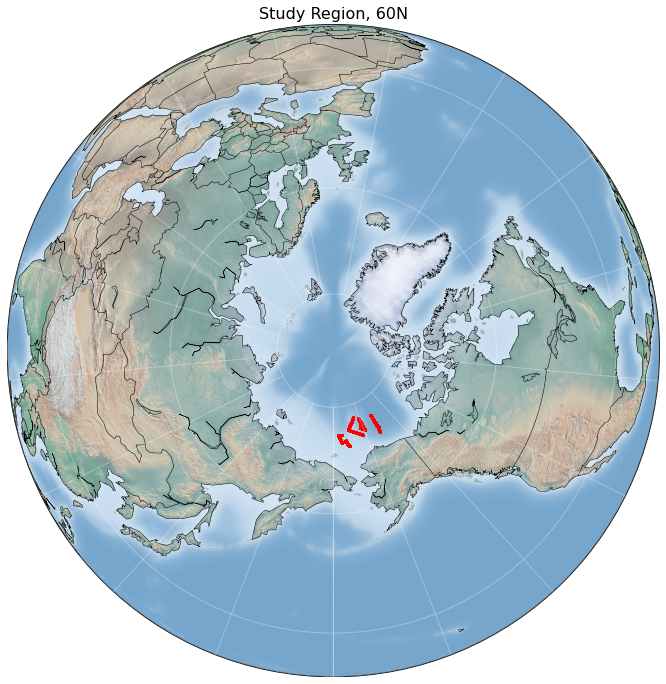

In [22]:
# run with oython >= 3.8 or install Basemap on Ubuntu

make_the_map(xlon_series, ylat_series)

In [23]:
ds_3cam['lon'].min()

183.211637

In [24]:
ds_3cam['lon'].max()

210.601029

## filter ATM locations

In [25]:
# extract transect by date
# filter for 19-april and then plot the transect for both my method and old method and then compare...


# transect = ds_3cam.loc[(ds_3cam['orbit_start'] >= '2016-04-17T00:00:00Z') & 
#                          (ds_3cam['orbit_start'] <= '2016-04-30T23:59:59Z')]  # should include T & Z?


In [26]:
# transect.head()

In [27]:
# extract transect by guessing longitudes

lon_start = 197
lon_end = 200

transect = ds_3cam.loc[(ds_3cam['lon'] > lon_start) &\
                        (ds_3cam['lon'] < lon_end)]
transect.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4398 entries, 0 to 41175
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   path                4398 non-null   int64  
 1   orbit               4398 non-null   int64  
 2   block               4398 non-null   int64  
 3   line                4398 non-null   int64  
 4   sample              4398 non-null   int64  
 5   lat                 4398 non-null   float64
 6   lon                 4398 non-null   float64
 7    an                 4398 non-null   float64
 8    ca                 4398 non-null   float64
 9    cf                 4398 non-null   float64
 10  mean_ATM_roughness  4398 non-null   float64
 11   weight             4398 non-null   float64
 12  npts                4398 non-null   float64
 13   cloud              4398 non-null   int64  
 14   var                4398 non-null   float64
dtypes: float64(9), int64(6)
memory usage: 549.8 KB


In [28]:
transect['lon'].min()

197.090105

In [29]:
transect['lon'].max()

199.999997

In [30]:
# define a box on map to zoom in to it

# my_coords_xy = [xlon_series[1], ylat_series[1]]
# print(my_coords)


# # # How much to zoom from coordinates (in degrees)
# # zoom_scale = 1

# # # Setup the bounding box for the zoom and bounds of the map
# # bbox = [my_coords_xy[0]-zoom_scale, my_coords_xy[0]+zoom_scale,\
# #         my_coords_xy[1]-zoom_scale, my_coords_xy[1]+zoom_scale]

llclat = transect['lat'].min()
llclon = transect['lon'].min()

urclon = transect['lon'].max()
urclat = transect['lat'].max()

print(llclat)
print(llclon)
print(urclat)
print(urclon)


74.11511
197.090105
77.29180699999999
199.999997


0

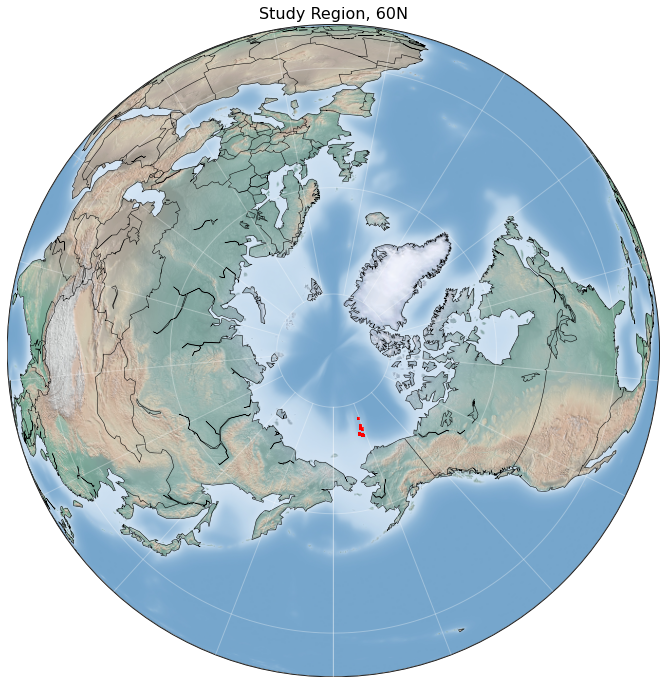

In [31]:
# run with oython >= 3.8 or install Basemap on Ubuntu

# make_the_map_with_zoom(transect['lon'], transect['lat'], llclat, llclon, urclon, urclat)
make_the_map(transect['lon'], transect['lat'])
# make_the_map2(transect['lon'], transect['lat'], llclat, llclon, urclon, urclat)

In [32]:
# make_the_map2(transect['lon'], transect['lat'], llclat, llclon, urclon, urclat)

In [33]:
# label output file

name_tag = 'inSample_'
date_tag = 'lon'+str(lon_start)+'_'+str(lon_end)+'_'
output_filename = name_tag+date_tag+trainDS_csv.split('.')[0]+'.csv'
output_filename

'inSample_lon197_200_atmmodel_july_2016_1to16.csv'

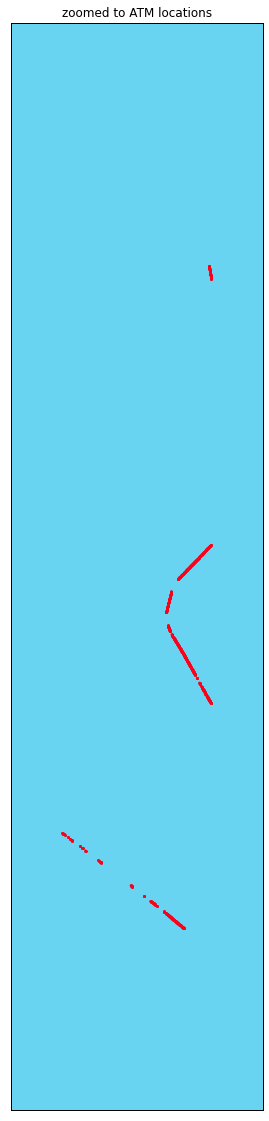

In [34]:

# terror_sl = terror_data[(terror_data.country_txt == 'Sri Lanka')]
lon_min, lon_max = llclon, urclon
lat_min, lat_max = llclat, urclat

# idx_sl = (terror_sl["longitude"]>lon_min) &\
#             (terror_sl["longitude"]<lon_max) &\
#             (terror_sl["latitude"]>lat_min) &\
#             (terror_sl["latitude"]<lat_max)
            
# terror_attacks_lk = terror_sl[idx_sl].sample(n=1000)
            
# Mercator of China
plt.figure(2, figsize=(20,20))

m2 = Basemap(projection='merc',
             llcrnrlat=lat_min-1,
             urcrnrlat=lat_max+1,
             llcrnrlon=lon_min-1,
             urcrnrlon=lon_max+1,
             lat_ts=35,
             resolution='c')

m2.fillcontinents(color='yellow',lake_color='#000000') # yellow land, black lakes
m2.drawmapboundary(fill_color='#68d4f2')                # light blue
m2.drawcountries(linewidth=0.3, color="w")              # thin white line for country borders

# Plot the data
mxy = m2(transect['lon'].tolist(), transect['lat'].tolist())

m2.scatter(mxy[0], mxy[1], s=5, c="#ff0019", lw=0, alpha=0.5, zorder=5)

plt.title("zoomed to ATM locations")
plt.show()


In [35]:
# # needs work: how define corners for ortho? else the whole globe is plotted!

# # terror_sl = terror_data[(terror_data.country_txt == 'Sri Lanka')]
# lon_min, lon_max = llclon, urclon
# lat_min, lat_max = llclat, urclat

# # idx_sl = (terror_sl["longitude"]>lon_min) &\
# #             (terror_sl["longitude"]<lon_max) &\
# #             (terror_sl["latitude"]>lat_min) &\
# #             (terror_sl["latitude"]<lat_max)
            
# # terror_attacks_lk = terror_sl[idx_sl].sample(n=1000)
            
# # Mercator of China
# plt.figure(2, figsize=(20,10))

# m2 = Basemap(projection='ortho', lat_0=90, lon_0=180,
#              llcrnrlat=lat_min-1,
#              urcrnrlat=lat_max+1,
#              llcrnrlon=lon_min-1,
#              urcrnrlon=lon_max+1,
#              resolution='c')

# m2.fillcontinents(color='yellow',lake_color='#000000') # yellow land, black lakes
# m2.drawmapboundary(fill_color='#68d4f2')                # light blue
# m2.drawcountries(linewidth=0.3, color="w")              # thin white line for country borders

# # Plot the data
# mxy = m2(transect['lon'].tolist(), transect['lat'].tolist())

# m2.scatter(mxy[0], mxy[1], s=5, c="#ff0019", lw=0, alpha=0.5, zorder=5)

# plt.title("view of events")
# plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


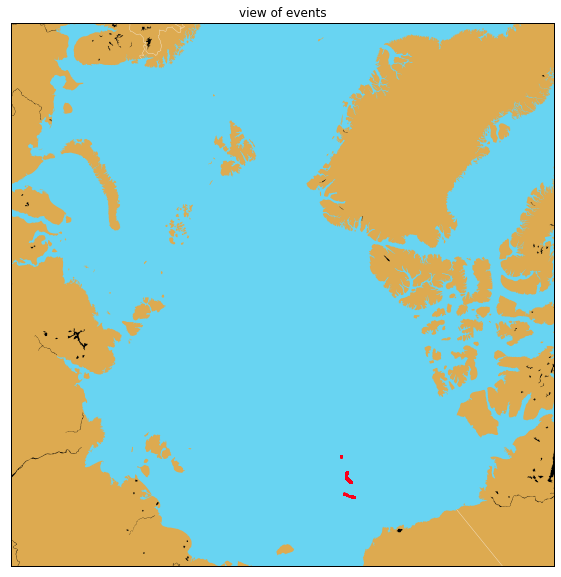

In [36]:
# needs work: how define corners for ortho? else the whole globe is plotted!

# terror_sl = terror_data[(terror_data.country_txt == 'Sri Lanka')]
lon_min, lon_max = llclon, urclon
lat_min, lat_max = llclat, urclat

# idx_sl = (terror_sl["longitude"]>lon_min) &\
#             (terror_sl["longitude"]<lon_max) &\
#             (terror_sl["latitude"]>lat_min) &\
#             (terror_sl["latitude"]<lat_max)
            
# terror_attacks_lk = terror_sl[idx_sl].sample(n=1000)
            
# Mercator of China
plt.figure(2, figsize=(20,10))

m2 = Basemap(projection='npstere', #, lat_0=90, lon_0=180,
            lon_0=180,
            boundinglat=70,
            resolution='i')

m2.fillcontinents(color='#ddaa50',lake_color='#000100') # yellow land, black lakes
m2.drawmapboundary(fill_color='#68d4f2')                # light blue
m2.drawcountries(linewidth=0.3, color="w")              # thin white line for country borders

# Plot the data
mxy = m2(transect['lon'].tolist(), transect['lat'].tolist())

m2.scatter(mxy[0], mxy[1], s=5, c="#ff0019", lw=0, alpha=0.5, zorder=5)

m2.etopo()

plt.title("view of events")
plt.show()


In [37]:
# '''
# so far, the best
# to do: 
# change land color and sea color
# maybe add names to land?
# larger map?


# ''' 

# import plotly.graph_objects as go

# # fig = go.Figure(go.Scattergeo())
# # fig.update_geos(projection_type="stereographic")
# # fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
# # fig.show()



# # df = ds_3cam
# df = transect
# fig = go.Figure(data=go.Scattergeo(
#         lon = df['lon'],
#         lat = df['lat'],
#         mode = 'markers',
#         marker_color = df['mean_ATM_roughness'],
#         ))

# fig.update_geos(projection_type="stereographic")

# fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})



# fig.show()


## write out data

In [38]:
output_fp = os.path.join(trainDS_dir, output_filename)
transect.to_csv(output_fp, index=False)
output_fp

'/Volumes/SEAGATE/july_2016/inSample_lon197_200_atmmodel_july_2016_1to16.csv'